In [ ]:
"""
In this notebook, one example of simon's algorithm will be modeled using both IBM Qiskit and pgmpy.
The results are compared at the end.
"""

In [3]:
# Comment out these lines
import sys
sys.path.insert(0, 'C:\\Users\\masch\\QuantumComputing\\QComp\\pgmpy')

# Imports (some imports may not be necessary)
import numpy as np
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, assemble, transpile
from qiskit.visualization import plot_histogram
import qiskit.quantum_info as qi

from qiskit.dagcircuit import DAGCircuit
from qiskit.converters import circuit_to_dag
from qiskit.visualization import dag_drawer

# set the length of the n-bit input string. 

n = 2
m = 2

# Construct the oracle
oracle = QuantumCircuit(n+m)
#oracle.barrier()
oracle.cx(0,2)
oracle.cx(0,3)
oracle.cx(1,2)
oracle.cx(1,3)
#oracle.barrier()
oracle.draw()

q_0: ──■────■────────────
       │    │            
q_1: ──┼────┼────■────■──
     ┌─┴─┐  │  ┌─┴─┐  │  
q_2: ┤ X ├──┼──┤ X ├──┼──
     └───┘┌─┴─┐└───┘┌─┴─┐
q_3: ─────┤ X ├─────┤ X ├
          └───┘     └───┘

/var/folders/80/l0hfnvbn49g0wln3399w9jzc0000gn/T/ipykernel_2387/3560922066.py:6: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  simonAlg += oracle


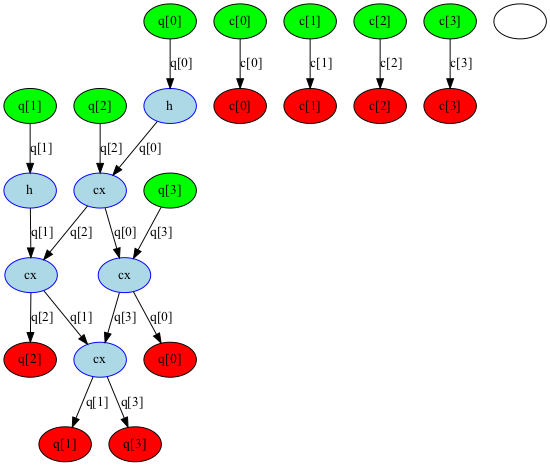

In [4]:
# The next 3 cells show the construction of the entire circuit
simonAlg = QuantumCircuit(n+m,n+m)
#simonAlg.barrier()
for qubit in range(n):
    simonAlg.h(qubit)
simonAlg += oracle
simonAlg.draw()

dag = circuit_to_dag(simonAlg)
dag_drawer(dag)

In [5]:
for qubit in range(n):
    simonAlg.h(qubit)
simonAlg.barrier()
simonAlg.draw()

┌───┐          ┌───┐           ░ 
q_0: ┤ H ├──■────■──┤ H ├───────────░─
     ├───┤  │    │  └───┘     ┌───┐ ░ 
q_1: ┤ H ├──┼────┼────■────■──┤ H ├─░─
     └───┘┌─┴─┐  │  ┌─┴─┐  │  └───┘ ░ 
q_2: ─────┤ X ├──┼──┤ X ├──┼────────░─
          └───┘┌─┴─┐└───┘┌─┴─┐      ░ 
q_3: ──────────┤ X ├─────┤ X ├──────░─
               └───┘     └───┘      ░ 
c: 4/═════════════════════════════════

In [6]:
# Here, we obtain the state vector for the system after the cx gate
simon = qi.Statevector.from_instruction(simonAlg)
simonVec = simon.__array__()

# The format of the state vector is [|0000>, |1000>, |0100>, |1100>, ...]
print(simonVec)

[ 0.5+0.j  0. +0.j  0. +0.j  0.5+0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j
  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0.5+0.j  0. +0.j  0. +0.j -0.5+0.j]


In [7]:
# Imports
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete.CPD import TabularCPD
import numpy as np
from pgmpy.inference import VariableElimination

# Bayesian Network for Simon's Algorithm
simon = BayesianNetwork([('q0m0', 'q0m1'), ('q0m1', 'q0m2'), ('q1m0', 'q1m1'), ('q1m1', 'q1m2'), ('q2m0', 'q2m1'), ('q2m1', 'q2m2'), ('q3m0', 'q3m1'), ('q3m1', 'q3m2'), ('q0m1', 'q2m2'), ('q0m1', 'q3m2'), ('q1m1', 'q2m2'), ('q1m1', 'q3m2'), ('q0m2', 'q0m3'), ('q1m2', 'q1m3')])

# Conditional Amplitude Tables
cpd_q0m0 = TabularCPD(variable = 'q0m0', variable_card = 2, values = [[1], [0]])
cpd_q1m0 = TabularCPD(variable = 'q1m0', variable_card = 2, values = [[1], [0]])
cpd_q2m0 = TabularCPD(variable = 'q2m0', variable_card = 2, values = [[1], [0]])
cpd_q3m0 = TabularCPD(variable = 'q3m0', variable_card = 2, values = [[1], [0]])
cpd_q0m1 = TabularCPD(variable='q0m1', variable_card = 2, values = [[1/np.sqrt(2), 1/np.sqrt(2)], [1/np.sqrt(2), -1/np.sqrt(2)]], evidence = ['q0m0'], evidence_card = [2])
cpd_q1m1 = TabularCPD(variable='q1m1', variable_card = 2, values = [[1/np.sqrt(2), 1/np.sqrt(2)], [1/np.sqrt(2), -1/np.sqrt(2)]], evidence = ['q1m0'], evidence_card = [2])
cpd_q2m1 = TabularCPD(variable='q2m1', variable_card = 2, values = [[1, 0], [0, 1]], evidence = ['q2m0'], evidence_card = [2])
cpd_q3m1 = TabularCPD(variable='q3m1', variable_card = 2, values = [[1, 0], [0, 1]], evidence = ['q3m0'], evidence_card = [2])
cpd_q0m2 = TabularCPD(variable='q0m2', variable_card = 2, values = [[1, 0], [0, 1]], evidence = ['q0m1'], evidence_card = [2])
cpd_q1m2 = TabularCPD(variable='q1m2', variable_card = 2, values = [[1, 0], [0, 1]], evidence = ['q1m1'], evidence_card = [2])
cpd_q2m2 = TabularCPD(variable='q2m2', variable_card = 2, values = [[1,0,0,1,0,1,1,0],[0,1,1,0,1,0,0,1]], evidence = ['q0m1', 'q1m1', 'q2m1'], evidence_card = [2,2,2])
cpd_q3m2 = TabularCPD(variable='q3m2', variable_card = 2, values = [[1,0,0,1,0,1,1,0],[0,1,1,0,1,0,0,1]], evidence = ['q0m1', 'q1m1', 'q3m1'], evidence_card = [2,2,2])
cpd_q0m3 = TabularCPD(variable='q0m3', variable_card = 2, values = [[1/np.sqrt(2), 1/np.sqrt(2)], [1/np.sqrt(2), -1/np.sqrt(2)]], evidence = ['q0m2'], evidence_card = [2])
cpd_q1m3 = TabularCPD(variable='q1m3', variable_card = 2, values = [[1/np.sqrt(2), 1/np.sqrt(2)], [1/np.sqrt(2), -1/np.sqrt(2)]], evidence = ['q1m2'], evidence_card = [2])

# Add CADs to Bayesian Network 
simon.add_cpds(cpd_q0m0, cpd_q1m0, cpd_q2m0, cpd_q3m0, cpd_q0m1, cpd_q1m1, cpd_q2m1, cpd_q3m1, cpd_q0m2, cpd_q1m2, cpd_q2m2, cpd_q3m2, cpd_q0m3, cpd_q1m3)
simonInfer = VariableElimination(simon)

# Print Results of Variable Elimination (pay attention to the ordering of variables) 
q = simonInfer.query(['q0m3', 'q1m3', 'q2m2', 'q3m2'])
print(q)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

+---------+---------+---------+---------+----------------------------+
| q0m3    | q1m3    | q2m2    | q3m2    |   phi(q0m3,q1m3,q2m2,q3m2) |
+=========+=========+=========+=========+============================+
| q0m3(0) | q1m3(0) | q2m2(0) | q3m2(0) |             0.5000+0.0000j |
+---------+---------+---------+---------+----------------------------+
| q0m3(0) | q1m3(0) | q2m2(0) | q3m2(1) |             0.0000+0.0000j |
+---------+---------+---------+---------+----------------------------+
| q0m3(0) | q1m3(0) | q2m2(1) | q3m2(0) |             0.0000+0.0000j |
+---------+---------+---------+---------+----------------------------+
| q0m3(0) | q1m3(0) | q2m2(1) | q3m2(1) |             0.5000+0.0000j |
+---------+---------+---------+---------+----------------------------+
| q0m3(0) | q1m3(1) | q2m2(0) | q3m2(0) |             0.0000+0.0000j |
+---------+---------+---------+---------+----------------------------+
| q0m3(0) | q1m3(1) | q2m2(0) | q3m2(1) |             0.0000+0.0000j |
+-----

/opt/anaconda3/lib/python3.9/site-packages/pgmpy-0.1.16-py3.9.egg/pgmpy/extern/tabulate.py:282: ComplexWarning: Casting complex values to real discards the imaginary part


In [8]:
# Obtain the ordering of the variables in the display above, as well as their values
qVars = q.variables
qValues = q.values

print(qVars)
print(qValues)

['q0m3', 'q1m3', 'q2m2', 'q3m2']
[[[[ 0.5+0.j  0. +0.j]
   [ 0. +0.j  0.5+0.j]]

  [[ 0. +0.j  0. +0.j]
   [ 0. +0.j  0. +0.j]]]


 [[[ 0. +0.j  0. +0.j]
   [ 0. +0.j  0. +0.j]]

  [[ 0.5+0.j  0. +0.j]
   [ 0. +0.j -0.5+0.j]]]]


In [9]:
def bitListBack(n):
    N = 2**n
    numList = []
    numFormat = "0" + str(n) + "b"
    for i in range(N):
        numList.append((str(format(i,numFormat))[::-1]))
    return numList

def QiskitDict(stateVec,n):
    qbits = bitListBack(n)
    QbitDict = {}
    for i in range(2**n):
        QbitDict[qbits[i]]=np.round(stateVec[i],4)
    return QbitDict

print("simon's algorithm")
print(QiskitDict(simonVec,4))

simon's algorithm
{'0000': (0.5+0j), '1000': 0j, '0100': 0j, '1100': (0.5+0j), '0010': 0j, '1010': 0j, '0110': 0j, '1110': 0j, '0001': 0j, '1001': 0j, '0101': 0j, '1101': 0j, '0011': (0.5+0j), '1011': 0j, '0111': 0j, '1111': (-0.5+0j)}


In [10]:
# Obtain the ordering of the variables in the display above, as well as their values
valArr = q.variables
valuesArr = q.values

def create_var_order(orderArr):
    currNum = 0
    numArr = []
    for order in orderArr:
        if len(order) == 4:
            currNum = order[1]
        numArr.append(currNum)
    return numArr

def bitList(n):
    N = 2**n
    numList = []
    numFormat = "0" + str(n) + "b"
    for i in range(N):
        numList.append((str(format(i,numFormat))))
    return numList


def columnize(listOfBits):
    n = len(listOfBits[0])
    holder = []
    for i in range(n):
        col = []
        for bit in listOfBits:
            col.append(bit[i])
        holder.append(col)
    return holder

def reform():
    varOrderArr = create_var_order(valArr)
    listOfBits = bitList(len(varOrderArr))
    columns = columnize(listOfBits)
    rearrangedColumns = [None]*len(columns)
    for index, order in enumerate(varOrderArr):
        rearrangedColumns[index] = columns[int(order)]
    numOfCols = len(rearrangedColumns)
    bitStr = ""
    finalBitArr = []
    for bitIndex in range(len(rearrangedColumns[0])):
        for num in range(numOfCols):
            bitStr+=str(rearrangedColumns[num][bitIndex])
        finalBitArr.append(bitStr)
        bitStr = ""
    return finalBitArr

def createHashTable():
    resHash = {}
    bitOrder=reform()
    valuesFlat = valuesArr.flatten()
    for index, key in enumerate(bitOrder):
        resHash[key] = np.round(valuesFlat[index], 4)
    return resHash

PgmpyHash = createHashTable()

print(PgmpyHash == QiskitDict(simonVec,4))
print(PgmpyHash)
print(QiskitDict(simonVec,4))

True
{'0000': (0.5+0j), '0001': 0j, '0010': 0j, '0011': (0.5+0j), '0100': 0j, '0101': 0j, '0110': 0j, '0111': 0j, '1000': 0j, '1001': 0j, '1010': 0j, '1011': 0j, '1100': (0.5+0j), '1101': 0j, '1110': 0j, '1111': (-0.5+0j)}
{'0000': (0.5+0j), '1000': 0j, '0100': 0j, '1100': (0.5+0j), '0010': 0j, '1010': 0j, '0110': 0j, '1110': 0j, '0001': 0j, '1001': 0j, '0101': 0j, '1101': 0j, '0011': (0.5+0j), '1011': 0j, '0111': 0j, '1111': (-0.5+0j)}
